In [9]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Object Detection

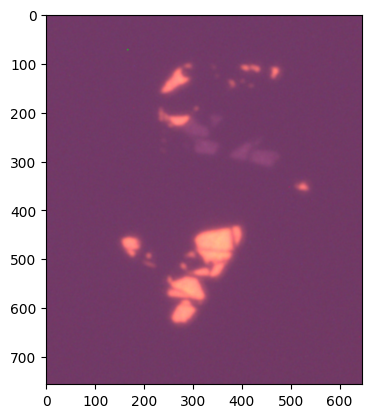

In [10]:
# Load images
tmds_bgr = cv.imread("images/TMDs.tif")
tmds_rgb = tmds_bgr[:,:,::-1]  # Convert BGR to RGB order

plt.imshow(tmds_rgb)

## Determine a threshold which isolates the desired object

Create a live thresholding window, and manually threshold the image

In [11]:
# Define image to threshold
img = tmds_rgb

# Create window
threshold_values = np.zeros((2,3), dtype=np.uint8)  # ((min,max), (min,max), (min,max))

window_name = "Live Threshold Picker, Press \"q\" or \"ESC\" to exit"
cv.namedWindow(window_name, cv.WINDOW_NORMAL)
# Create trackbars
cv.createTrackbar("C 1 Min", window_name, 0, 255, lambda x: None)
cv.createTrackbar("C 1 Max", window_name, 0, 255, lambda x: None)
cv.createTrackbar("C 2 Min", window_name, 0, 255, lambda x: None)
cv.createTrackbar("C 2 Max", window_name, 0, 255, lambda x: None)
cv.createTrackbar("C 3 Min", window_name, 0, 255, lambda x: None)
cv.createTrackbar("C 3 Max", window_name, 0, 255, lambda x: None)
# Set default trackbar positions
cv.setTrackbarPos("C 1 Max", window_name, 255)
cv.setTrackbarPos('C 2 Max', window_name, 255)
cv.setTrackbarPos('C 3 Max', window_name, 255)

# Create thresholded image array to display
thresholded = np.zeros_like(img)

# Loop while user making selection
# Try to read the information from the trackbars and return a live thresholded image
try:
    while True:
        # Get trackbar positions
        threshold_values[0,0] = cv.getTrackbarPos("C 1 Min", window_name)
        threshold_values[1,0] = cv.getTrackbarPos("C 1 Max", window_name)
        threshold_values[0,1] = cv.getTrackbarPos("C 2 Min", window_name)
        threshold_values[1,1] = cv.getTrackbarPos("C 2 Max", window_name)
        threshold_values[0,2]= cv.getTrackbarPos("C 3 Min", window_name)
        threshold_values[1,2]= cv.getTrackbarPos("C 3 Max", window_name)

        # Threshold the image. 
        # Set the thresholded pixels to the original image's pixels and out-of-thresholded pixels to 0 
        thresholded = cv.bitwise_and(
            img, img, 
            mask=cv.inRange(img, threshold_values[0], threshold_values[1])
            )
        
        # Rescale the image to display. TODO make this dynamic based on image size and display resolution
        # display = rescale_img(thresholded, scale)
        
        cv.imshow(window_name, thresholded)  # Update window with new image.
        key = cv.waitKey(10)  #How long to show image for before continuing in loop
        
        # Press q or ESC to exit
        if key == ord("q") or key == 27:  
            break
        
    cv.destroyWindow(window_name)
    
# If the above code throws an error (i.e. window is closed) break from loop
except Exception as exc:
    print(exc)

# Extract lower and upper thresholds
lower_threshold, upper_threshold = threshold_values

print(f"""
lower threshold: {lower_threshold}
upper threshold: {upper_threshold}
""")


lower threshold: [156   0   0]
upper threshold: [255 255 255]



## Threshold the image with the given settings

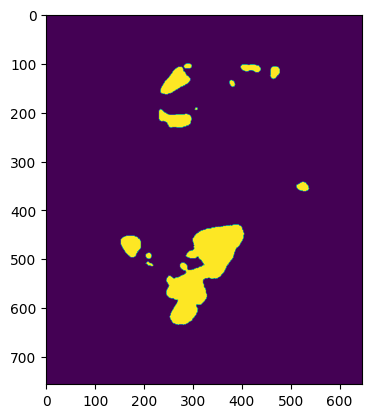

In [12]:
thresholded_img = cv.inRange(tmds_rgb, lower_threshold, upper_threshold)

plt.imshow(thresholded_img)

## Search for contours in the image

### What are contours?
Contours are a curve joining all the continuous points which have the same color or intensity. 

Use `cv.findContours(image, mode, method)`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0

This works best with binary images


The **mode** parameter changes how the heirarchy of discovered contours is returned: 

- `cv.RETR_EXTERNAL` : Retrieves only the extreme outer contours.

- `cv.RETR_LIST` : Retrieves all of the contours without establishing any hierarchical relationships.

- `cv.RETR_CCOMP` : Retrieves all of the contours and organizes them into a two-level hierarchy. 
   
    - At the top level, there are external boundaries of the components. 
   
    - At the second level, there are boundaries of the holes. If there is another contour inside a hole of a connected component, it is still put at the top level.

- `cv.RETR_TREE` : Retrieves all of the contours and reconstructs a full hierarchy of nested contours.

- `cv.RETR_FLOODFILL` : No documentation :'(

The **methods** parameter changes how/how many contour points are stored and returned:

For more info on heirarchy see: https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html 

- `cv.CHAIN_APPROX_NONE :` stores absolutely all the contour points. 
    That is, any 2 subsequent points (x1,y1) and (x2,y2) of the contour will be either horizontal, vertical or diagonal neighbors, that is, max(abs(x1-x2),abs(y2-y1))==1.

- `cv.CHAIN_APPROX_SIMPLE` : compresses horizontal, vertical, and diagonal segments and leaves only their end points. 
    For example, an up-right rectangular contour is encoded with 4 points.

- `cv.CHAIN_APPROX_TC89_L1` : applies one of the flavors of the Teh-Chin chain approximation algorithm [1]

- `cv.CHAIN_APPROX_TC89_KCOS` : applies one of the flavors of the Teh-Chin chain approximation algorithm [1]


*[1] : C-H Teh and Roland T. Chin. On the detection of dominant points on digital curves. Pattern Analysis and Machine Intelligence, IEEE Transactions on, 11(8):859–872, 1989.*

In [13]:
# Find contours in thresholded image
contours, heirarchy = cv.findContours(thresholded_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

print(f"Contours found: {len(contours)}")

Contours found: 12


### Display contours
Use `cv.drawContours(image, contours, contour_ids, colour, line_thickness)`  https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc

**contour_ids** is the id of the contour to draw. Use `-1` to draw all contours

Text(0.5, 1.0, 'Contours on threshold img')

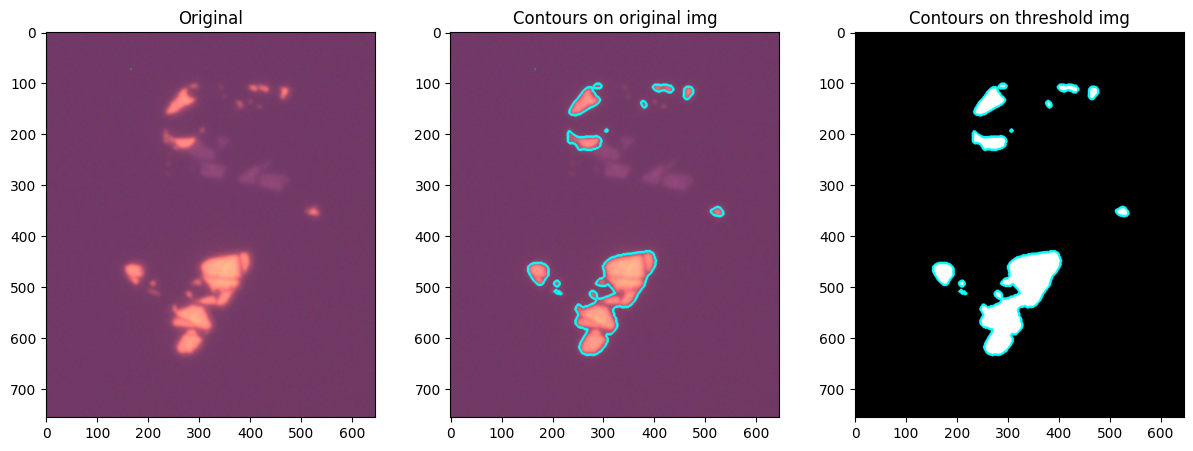

In [14]:
# Define line parameters
colour = (0, 255, 255)
thickness = 3

# Draw contours on original image
drawn_contours = cv.drawContours(img.copy(), contours, -1, colour, thickness)

# Draw contours on thresholded image - convert to colour image for annotations
threshold_drawn_contours = cv.drawContours(cv.cvtColor(thresholded_img.copy(), cv.COLOR_GRAY2RGB), contours, -1, colour, thickness)

# Display images
plt.figure(figsize=(20,5))
plt.subplot(141); plt.imshow(img); plt.title("Original")
plt.subplot(142); plt.imshow(drawn_contours); plt.title("Contours on original img")
plt.subplot(143); plt.imshow(threshold_drawn_contours); plt.title("Contours on threshold img")

## Image Moments / Contour Features
The Moments of an image or contour are defined as:

$ M_{{ij}}=\sum _{x}\sum _{y}x^{i}y^{j}I(x,y)\,\! $

The 0th order moment $\left( M_{00} \right)$ $(i=0, j=0)$ simply sums the pixel values, and so for a binary image this is equivalent to the **area** of pixels in the image with values of 1.

The 1st order moments $\left( M_{10} \right)$ & $\left( M_{01} \right)$ can be used to find the **centroid** (or the centre point of the object) in the image by dividing by $M_{00}$ :
- x centroid = $ M_{10}/M_{00}$
- y centroid = $ M_{01}/M_{00}$

Image moments can also be converted into a translation invariant form known as Central moments.

Image moments can also be used to derive orientation and scale.

For more information see: https://en.wikipedia.org/wiki/Image_moment

OpenCV gives you access to the moments of a contour with: 

`M = cv.moments(contour)`

The individual moments of the contour can be accesed like:

Area:

- `area = M['m00']`

or alternately using:

- `area = cv.contourArea(contour)`

Centroids:
- `x_centroid = M['m10'] / M['m00']`
- `y_centroid = M['m01'] / M['m00']`

In [15]:
# Getting the area of contours
areas = [cv.contourArea(contour) for contour in contours]

def calculate_centroids(contour) -> tuple[int,int]:
    m = cv.moments(contour)
    x = m["m10"] / m["m00"]
    y = m["m01"] / m["m00"]
    return (int(x), int(y))

centroids = [calculate_centroids(contour) for contour in contours]
    

### Display centroids

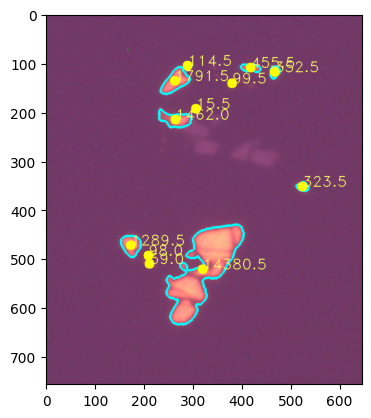

In [16]:
# Create copy to avoid editing original
img_centroids = drawn_contours.copy()  

# Draw a circle for every centroid and add text for area
for centroid, area in zip(centroids, areas):
    cv.circle(img_centroids, centroid, radius=10, color=(255,255,0), thickness=cv.FILLED)
    cv.putText(img_centroids, str(area), centroid, cv.FONT_HERSHEY_DUPLEX, fontScale=1, color=(255,255,100))

plt.imshow(img_centroids)

### Contour Perimiter (Arc Length)
Calculate the length of the countour's perimiter 

Use `cv.arcLength(contour, closed:bool)`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga8d26483c636be6b35c3ec6335798a47c

Set the closed parameter to True if the contour has no gaps in it's perimiter, or False otherwise

In [37]:
perimiter = cv.arcLength(contours[0], True)

print(f"Contour 0 has perimiter length: {perimiter:0.2f}")

Contour 0 has perimiter length: 35.80


## Contour Approximations
When a simpler, more appropriate contour shape is desired than the one calculated, the following methods can be used to reduce the number of verticies.

The algorithm provided in OpenCV (`cv.approxPolyDP(contour, epsilon, closed:bool)`)  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c

It is an implementation of the Douglas-Peucker algorithm.  https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm

The **epsilon** parameter is the maximum distance from the contour to the approximated contour, this must be chosen carefully.

The **closed** parameter should be set appropriately for if the contour is closed or not.

In [18]:
# Load example image
poor_mask = cv.imread("images/Contour_approximation.png", cv.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'Simplified Contour')

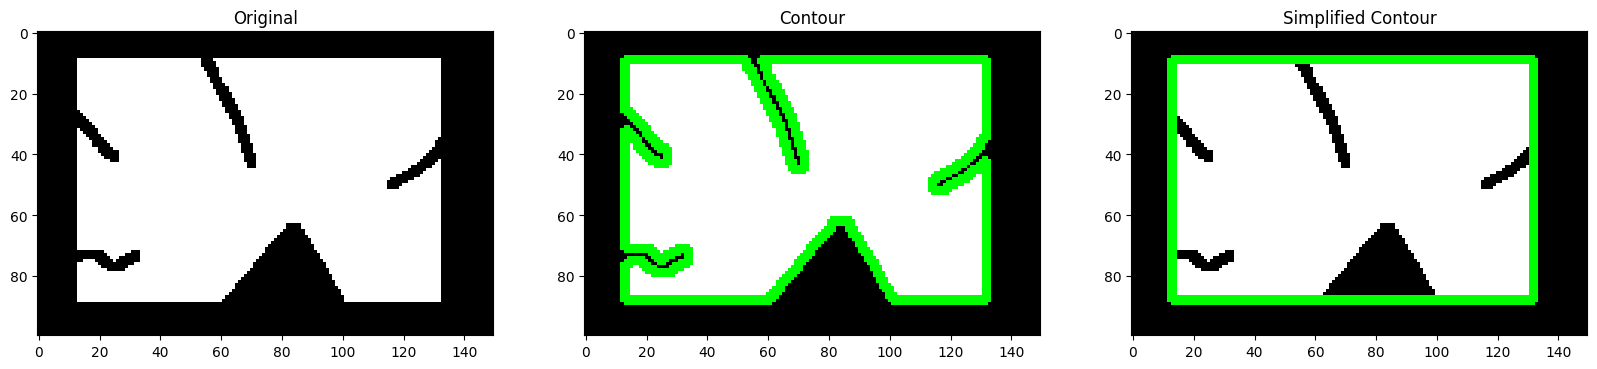

In [19]:
# Determine contours
poor_contour, heirarchy = cv.findContours(poor_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# Draw contours (with colour)
drawn_poor_contours = cv.drawContours(cv.cvtColor(poor_mask.copy(), cv.COLOR_GRAY2RGB), poor_contour, 0, color=(0,255,0), thickness=2)

# Simply contour
epsilon = 0.1 * cv.arcLength(poor_contour[0], closed=True)
simplified_contour = cv.approxPolyDP(poor_contour[0], epsilon, closed=True)

# Draw simplified contour
drawn_simplified_contour = cv.drawContours(cv.cvtColor(poor_mask.copy(), cv.COLOR_GRAY2RGB), [simplified_contour], -1, color=(0,255,0), thickness=2)

# Display figures
plt.figure(figsize=(20,5))
plt.subplot(131); plt.imshow(poor_mask, cmap="gray"); plt.title("Original")
plt.subplot(132); plt.imshow(drawn_poor_contours); plt.title("Contour")
plt.subplot(133); plt.imshow(drawn_simplified_contour); plt.title("Simplified Contour")

## Convex Hull

Use `cv.convexHull(contour)`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656

Although seemingly similar to the contour approximation above in it's output, this algorithm functions very differently.

It seeks so called convexity defects (bulges inwards) in the given contour and simplifies the contour by excluding them.

Text(0.5, 1.0, 'Convex Hull')

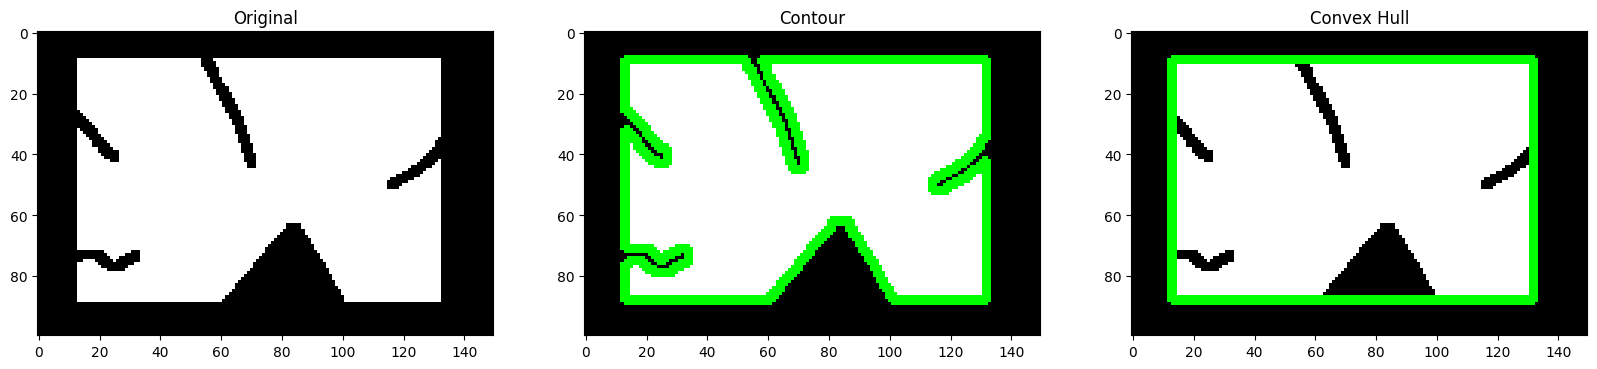

In [20]:
# Determine contours
poor_contour, heirarchy = cv.findContours(poor_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# Draw contours (with colour)
drawn_poor_contours = cv.drawContours(cv.cvtColor(poor_mask.copy(), cv.COLOR_GRAY2RGB), poor_contour, 0, color=(0,255,0), thickness=2)

# Calculate convex hull
convex_hull = cv.convexHull(poor_contour[0])

# Draw simplified contour
drawn_simplified_contour = cv.drawContours(cv.cvtColor(poor_mask.copy(), cv.COLOR_GRAY2RGB), [convex_hull], -1, color=(0,255,0), thickness=2)

# Display figures
plt.figure(figsize=(20,5))
plt.subplot(131); plt.imshow(poor_mask, cmap="gray"); plt.title("Original")
plt.subplot(132); plt.imshow(drawn_poor_contours); plt.title("Contour")
plt.subplot(133); plt.imshow(drawn_simplified_contour); plt.title("Convex Hull")

### Checking Convexity
Use `cv.isContourConvex(contour)` to determine if a contour has convexity defects.

`True` = no defects, `False` = defects

In [21]:
is_convex:bool = cv.isContourConvex(poor_contour[0])
is_convex_simplified:bool = cv.isContourConvex(simplified_contour)

print(f"""
Poor contour is convex: {is_convex}
Simplified contour is convex: {is_convex_simplified}
""")


Poor contour is convex: False
Simplified contour is convex: True



## Bounding rectangles
Quite often it is desirable to be able to draw a bounding rectangle around a contour, this can draw a person's attention to a specific region easily, or it can be used as an input for object tracking algorithms.

There are 2 types of bounding rectangles that openCV can produce:
- Straight, use `cv.boundingRect(contour)`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga103fcbda2f540f3ef1c042d6a9b35ac7
- Rotated (minimum area), use `cv.minAreaRect(contour)`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga3d476a3417130ae5154aea421ca7ead9

In [22]:
# Select the largest contour
largest_contour = sorted(contours, key=lambda c:cv.contourArea(c), reverse=True)[0]

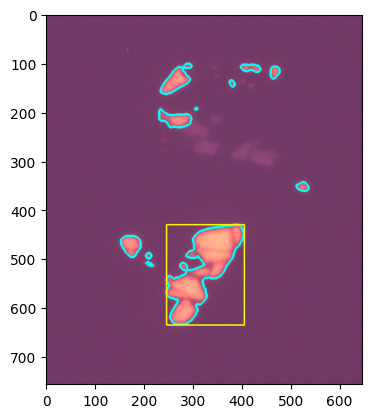

In [23]:
# Straight bounding box
x, y, w, h = cv.boundingRect(largest_contour)
bounding_box = cv.rectangle(drawn_contours.copy(), (x,y), (x+w, y+h), color=(255,255,0), thickness=2)
plt.imshow(bounding_box)

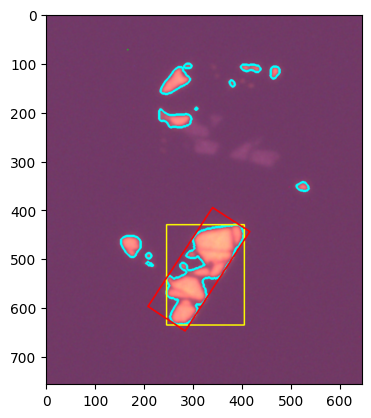

In [24]:
# Rotated (min area) bounding box
rectangle = cv.minAreaRect(largest_contour)  # Returns the rectangle as a cv.Box2D object. Which has properties: (centre (x,y), (width,height), angle of rotation)

# Find 4 corners of the rectangle
box = cv.boxPoints(rectangle)  
box = np.int64(box)  # Convert to needed type integer 64bit

# Draw bounding box
min_bounding_box = cv.drawContours(bounding_box.copy(), [box], 0, color=(255,0,0), thickness=2)

plt.imshow(min_bounding_box)

## Enclosing Circle
Find the smallest circle which encloses the contour with: `cv.minEnclosingCircle(contour)`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga8ce13c24081bbc7151e9326f412190f1

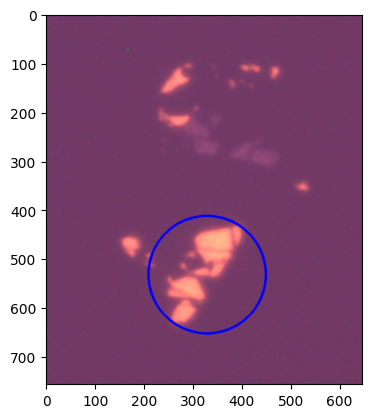

In [25]:
# Find the smallest circle which encloses the largest contour
(x,y), radius = cv.minEnclosingCircle(largest_contour)

# Convert to appropriate type
center = (int(x), int(y))
radius = int(radius)

# Draw enclosing circle
min_circle = cv.circle(img.copy(), center, radius, color=(0,0,255), thickness=3)

plt.imshow(min_circle)

## Fitting an Ellipse 
Use `cv.fitEllipse(contour)`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gaf259efaad93098103d6c27b9e4900ffa

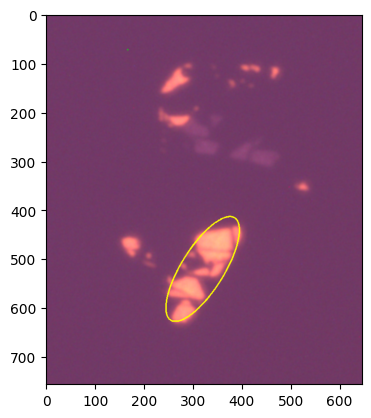

In [26]:
# Compute ellipse
ellipse = cv.fitEllipse(largest_contour)

# Draw ellipse
ellipse_img = cv.ellipse(img.copy(), ellipse, color=(255,255,0), thickness=2)

plt.imshow(ellipse_img)

## Fitting a line
Use `cv.fitLine`  https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gaf849da1fdafa67ee84b1e9a23b93f91f

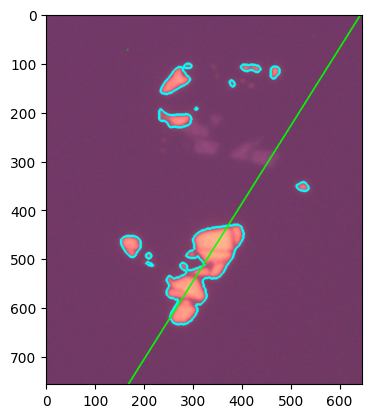

In [27]:
# Fit the line
vx, vy, x, y = cv.fitLine(largest_contour, cv.DIST_L2, 0, 0.01, 0.01)

# Get the width (or number of columns)
cols = img.shape[1]

lefty = int( (-x * vy / vx) + y )
righty = int( ((cols - x) * vy / vx) + y )

# Draw the line
fitted_line = cv.line(drawn_contours.copy(), (cols-1,righty), (0,lefty), color=(0,255,0), thickness=2)

plt.imshow(fitted_line)

## Contour Properties
Some of the properties which can be determined by using contours include:
- **Aspect Ratio**, the ratio of width to height of the contour's bounding box
- **Extent**, the ratio of a contour's area to that of it's bounding box
- **Solidity**, the ratio of a contour's area to that of it's convex hull area
- **Equivalent Diameter**, the diameter of a circle whose area is equivalent to that of the contour's area
- **Orientation**, the angle at which the object is pointing
- **Pixel Points**, a list of the points for a contour
- **Max/min values and their locations**
- **Mean colour/intensity**, determine the mean colour or intensity enclosed by the contour
- **Extreme points**, determine the top-, botton-, right-, and left-most points of the contour

### Aspect Ratio

In [28]:
x,y,w,h = cv.boundingRect(largest_contour)  # Determine the bounding box of a contour

aspect_ratio = w / h

print(f"Aspect Ratio: {aspect_ratio:0.4f}")  # Display aspect ratio to 4 decimal places

Aspect Ratio: 0.7756


### Extent

In [29]:
# Calculate area of contour
area = cv.contourArea(largest_contour)

# Calculate area of bounding box
x,y,w,h = cv.boundingRect(largest_contour)
bbox_area = w * h

# Calculate extent
extent = area / bbox_area

print(f"Extent: {extent:0.4f}")  # Display extent to 4 decimal places

Extent: 0.4412


### Solidity

In [30]:
area = cv.contourArea(largest_contour)

hull = cv.convexHull(largest_contour)
hull_area = cv.contourArea(hull)

solidity = area / hull_area

print(f"Solidity: {solidity:0.4f}")  # Display solidity to 4 decimal places

Solidity: 0.8037


### Equivalent Diameter

In [31]:
area = cv.contourArea(largest_contour)

equivalent_diameter = np.sqrt(4 * area / np.pi)

print(f"Equivalent Diameter: {equivalent_diameter:0.4f}")  # Display equivalent diameter to 4 decimal places

Equivalent Diameter: 135.3138


### Orientation

In [32]:
(x,y), (major_axis, minor_axis), angle = cv.fitEllipse(largest_contour)

print(f"""
Orientation angle: {angle:0.4f}
Major axis: {major_axis:0.4f}
Minor axis: {minor_axis:0.4f}
""")


Orientation angle: 32.0473
Major axis: 87.1373
Minor axis: 246.7454



### Pixel Points

In [33]:
# Create mask for contour
contour_mask = np.zeros(img.shape[:2], dtype=np.uint8)  # single channel array
contour_mask = cv.drawContours(contour_mask, [largest_contour], 0, 255, cv.FILLED)

pixel_points = cv.findNonZero(contour_mask)

print(pixel_points)

[[[383 430]]

 [[384 430]]

 [[385 430]]

 ...

 [[271 634]]

 [[280 634]]

 [[281 634]]]


### Max/Min value and locations

In [34]:
# Create mask for contour
contour_mask = np.zeros(img.shape[:2], dtype=np.uint8)  # single channel array
contour_mask = cv.drawContours(contour_mask, [largest_contour], 0, 255, cv.FILLED)

# Split into R, G, and B components
r,g,b = cv.split(img)

# Calculate min and max locations for each channel
r_min, r_max, r_min_location, r_max_loaction = cv.minMaxLoc(r, mask=contour_mask)
g_min, g_max, g_min_location, g_max_loaction = cv.minMaxLoc(g, mask=contour_mask)
b_min, b_max, b_min_location, b_max_loaction = cv.minMaxLoc(b, mask=contour_mask)

print(f"""
R Min: {int(r_min): ^3}, R Max: {int(r_max): ^3}, R Min Location: {r_min_location}, R Max Location{r_max_loaction}
G Min: {int(g_min): ^3}, G Max: {int(g_max): ^3}, G Min Location: {g_min_location}, G Max Location{g_max_loaction}
B Min: {int(b_min): ^3}, B Max: {int(b_max): ^3}, B Min Location: {b_min_location}, B Max Location{b_max_loaction}
""")


R Min: 156, R Max: 255, R Min Location: (377, 431), R Max Location(385, 437)
G Min: 66 , G Max: 190, G Min Location: (293, 484), G Max Location(354, 458)
B Min: 101, B Max: 149, B Min Location: (288, 489), B Max Location(339, 459)



### Mean Colour/Intensity

In [35]:
# Create contour mask
contour_mask = np.zeros(img.shape[:2], dtype=np.uint8)  # single channel array
contour_mask = cv.drawContours(contour_mask, [largest_contour], 0, 255, cv.FILLED)

# Find mean value of pixels in the mask
mean_value = cv.mean(img, mask=contour_mask)

print(f"Mean colour: {mean_value}")

Mean colour: (228.90660870746453, 123.77898526115602, 123.68681654554099, 0.0)


### Extreme Points


Left most point: [246 542]  
Right most point: [404 450]  
Top most point: [383 430]  
Bottom most point: [269 634]  



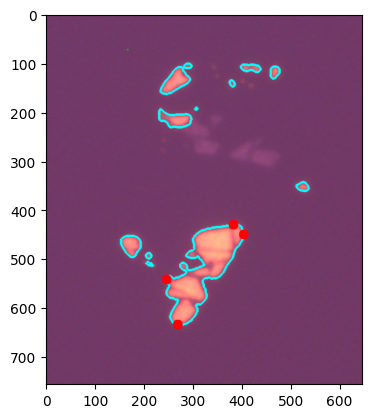

In [36]:
# Contours are a list of points comprising defining a curve
# Find the (x,y) coordinates for the points with: min x, max x, min y, max y
leftmost = largest_contour[largest_contour[:,:,0].argmin()][0]  # Point with minimum in x
rightmost = largest_contour[largest_contour[:,:,0].argmax()][0]  # Point with maximum in x
topmost = largest_contour[largest_contour[:,:,1].argmin()][0]  # Point with minimum in y
bottommost = largest_contour[largest_contour[:,:,1].argmax()][0]  # Point with maximum in y

print(f"""
Left most point: {leftmost}  
Right most point: {rightmost}  
Top most point: {topmost}  
Bottom most point: {bottommost}  
""")

# Draw points
extremes = drawn_contours.copy()
for point in (leftmost, rightmost, topmost, bottommost):
    cv.circle(extremes, point, radius=10, color=(255,0,0), thickness=cv.FILLED)

plt.imshow(extremes)